**Shape classifier**

Input: 1024 x 1024 color image and 1024 x 1024 image segmentation

Goal: Classify the different segments as being perfect shapes (rectangle, ellipse, 4-pointed star) or not; tag each segment with what it is; adjust the segmentation to closesly match the ideal perfect shape for each region; pass the updated segmentation and tags to the tracer

In [638]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, measure, draw
from skimage.color import rgb2gray, rgb2lab, lab2rgb
from skimage.segmentation import mark_boundaries
from scipy import ndimage
import math

In [278]:
# Name of png in test image folder to be segmented
fname = "5"

In [279]:
# Import image (PNG assumed), delete opacity info
def load_png(filename, downsample = False):
  '''Loads an image from a file'''
  image = io.imread("Test Images/" + filename + ".png")
  image = image[:, :, :3] # Remove alpha channel
  if downsample:
    image = image[::2, ::2] # Can adjust scaling factor
  return img_as_float(image)

In [280]:
# Import image and segmentation
image = load_png(fname)
segmentation = np.load('segmentation.npy')

In [281]:
# plt.figure(figsize=(6, 6))
# plt.imshow(image)

We will consider each given segment one at a time; the input to each sub-problem is a single segment and the entire image (or maybe we can use part of the image, where we use the bounding box of the segmentation to cut it down to a more manageable size).

In [282]:
# For a given segment, find the box of the image that we are concerned with
def bdbox(arr, value):
    # Find the indices where the value occurs
    x_indices, y_indices = np.where(arr == value)
    if len(x_indices) == 0:
        return None  # Value not found in the array
    # Calculate the bounding box
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()
    return (min_x, min_y, max_x, max_y)

def get_boxes(s, segmentation, bf = 8):
    bf = 8 # Buffer
    bb = bdbox(segmentation, s) # Bounding box
    test_box = image[max(0, bb[0] - bf):min(1024, bb[2] + bf), 
                    max(0, bb[1] - bf):min(1024, bb[3] + bf)]
    seg_box = segmentation[max(0, bb[0] - bf):min(1024, bb[2] + bf), 
                            max(0, bb[1] - bf):min(1024, bb[3] + bf)] == s
    return test_box, seg_box

In [283]:
# Marching squares algo for finding constant valued contours
def get_contours(s, test_box, seg_box, ovlp_thresh = 0.5, closed_tol = 1e-6):
    # Create the maps that contours are taken from
    t = []
    t.append(rgb2gray(test_box))
    for i in range(3):
        t.append(test_box[:, :, i])

    # Initialize list of good contours
    contours_good = []

    # Check if contour is closed
    def is_closed(contour, tolerance=closed_tol):
        return np.allclose(contour[0], contour[-1], atol=tolerance)

    # Find contours at a constant value of 0.8
    for i in range(3, 9):
        # Find all contours, keep the good ones
        for test in t:
            for contour in measure.find_contours(test, i / 10):
                if is_closed(contour):
                    # Check contour interior vs segment overlap
                    mask = np.zeros_like(seg_box, dtype=bool)
                    polygon = contour.squeeze()
                    rr, cc = draw.polygon(polygon[:, 0], polygon[:, 1], mask.shape)
                    mask[rr, cc] = 1

                    # Overlap:
                    ovlp_area = np.sum(np.logical_and(mask, seg_box))
                    tot_area = np.sum(np.logical_or(mask, seg_box))
                    set_res = ovlp_area / tot_area
                    
                    if set_res > ovlp_thresh:
                        contours_good.append(contour)
    return contours_good

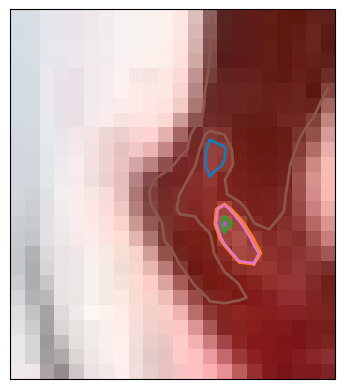

In [290]:
# CALC - Get contours for given s
# PROBLEM: Contour calculation very slow for larger regions, which is an issue
# We can maybe eliminate almost all regions from the beginning with a metric? Not sure

# for s in range(1):
s = 353
test_box, seg_box = get_boxes(s, segmentation)
# segmented_img = mark_boundaries(test_box, seg_box)
# plt.imshow(segmented_img)

gcont = get_contours(s, test_box, seg_box, 0, 10)
if len(gcont) > 0:
    # Display the image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(test_box, cmap=plt.cm.gray)
    for contour in gcont:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

TO DO THURS:

Shape detector:
- We want to detect perfect shapes; we can start by creating something which detects perfect shapes on a solid colors background with minimal aliasing - we can process a single contour and use math to see how close it is to the given perfect shape which fits perfectly to it in terms of axes, etc
- For a given contour, we want to test how close it is to a given perfect shape - we need to have perfect shapes (triangles, rectangles, ellipses, 4 point stars) at all rotations/place to test - this will require mathematical formulation;
    - For a given contour, we want to find the rectangle, ellipse, triangle and star of best fit with a mathematical formula - requires finding long axes - then find the error for each, one with lowest error is returned if below a given threshold
- Can use Hough transform possibly - 


Contour creator:
- Issue: many segments are poor and don't have a closed contour that contains them; if we have a shape on a solid background, we are OK, but otherwise we are kind of screwed
- In order to avoid this problem, we will try to create a better image segmentation using contours, as contouring seems much better than edge removal

- Ignore regions that are very small, these should not be snapped at all
- Create an upscaled segmentation using marching squares, then run tracing on it; maybe it will have more detail
- Contours detect aliasing

# Shape Detector 
Input: Points (floats) in a 2d grid which represent the boundary of a shape -- we will have an array of points, and these will be assumed to be sequentially the points that form the boundary of the closed shape

Output: The best ellipse, rectangle, triangle and 4-pointed star that fit to these points, along with the error of each (variance of pts from shape boundary, perhaps)

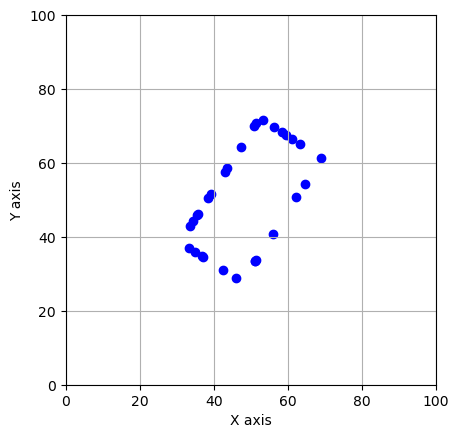

In [1021]:
# Create example point list using a region
import numpy as np
import matplotlib.pyplot as plt
import math

num_pt = 30 # num pts
sl = 100.0 # side length
bf = 5 # buffer

# Generate randomly spaced points
def random_pts(num_pt, sl, bf):
    return np.random.uniform(bf, sl - bf, size = (num_pt, 2))

# Generate random points on a given circle
def circ_pts(num_pt, r, center, offset = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        theta = np.random.uniform(0, 2 * np.pi) # random angle
        r_cur = r + np.random.uniform(-offset, offset) # radius offset
        pts[i, :] = center[0] + r_cur * np.cos(theta), center[1] + r_cur * np.sin(theta)
    return pts

# Generate random points on a given ellipse
def ell_pts(num_pt, a, b, center, offset = 0, angle = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        theta = np.random.uniform(0, 2 * np.pi) # random angle
        a_cur = a + np.random.uniform(-offset, offset)
        b_cur = b + np.random.uniform(-offset, offset)
        pts[i, :] = center[0] + a_cur * np.cos(theta), center[1] + b_cur * np.sin(theta)
    return rotate_pts(pts, center, angle)

# Generate random points on given rectangle
def rect_pts(num_pt, a, b, center, offset = 0, angle = 0):
    pts = np.zeros((num_pt, 2))
    for i in range(num_pt):
        off_cur = np.random.uniform(-offset, offset)
        if np.random.uniform(0, 1) < a / (a + b):
            pts[i, :] = center[0] + np.random.uniform(-a / 2, a / 2),  center[1] + off_cur + np.random.choice([-1, 1]) * (b / 2)
        else:
            pts[i, :] = center[0] + off_cur + np.random.choice([-1, 1]) * (a / 2), center[1] + np.random.uniform(-b / 2, b / 2)
    return rotate_pts(pts, center, angle)

# Generate random points on a given triangle
def tri_pts(num_pt, a, b, base, offset = 0):
    pts = np.zeros((num_pt, 2))
    hyp = np.sqrt((a / 2) ** 2 + b ** 2) # length of tilted side
    for i in range(num_pt):
        off_cur = np.random.uniform(-offset, offset)
        x = np.random.uniform(-a/2, a/2)
        if np.random.uniform(0, 1) > 2 * hyp / (2 * hyp + a):
            pts[i, :] = base[0] + x, base[1] + off_cur
        else:
            pts[i, :] = base[0] + x + off_cur * b ** 2 / hyp ** 2, base[1] + b * (1 - 2 * abs(x) / a) + off_cur * a ** 2 / (4 * hyp ** 2)
    return pts

# Given a set of points, rotate them around a center point by a certain amount
def rotate_pts(pts, center, theta):
    rot_pts = np.zeros_like(pts)
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    for i in range(rot_pts.shape[0]):
        translated = pts[i] - center
        rotated = np.dot(translated, rot_matrix.T)
        rot_pts[i, :] = rotated + center
    return rot_pts

# Show collection of points
def show_pts(pts, sl):
    plt.scatter(pts[:, 0], pts[:, 1], c='blue', marker='o')
    plt.grid(True)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, sl)
    plt.ylim(0, sl)
    # Set labels for clarity
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()

pt_rand = random_pts(num_pt, sl, bf)
pt_circ = circ_pts(num_pt, r = 20, center = [50, 50], offset = 1)
pt_ell = ell_pts(num_pt, a = 20, b = 40, center = [50, 50], offset = 3, angle = 1)
pt_rect = rect_pts(num_pt, 40, 20, [50, 50], 0, 1)
pt_tri = tri_pts(num_pt, 20, 40, [50, 50], 0)
show_pts(pt_rect, sl)

We have parameterized all the basic shapes, so what remains is an optimization problem. We will take the ellipse case for example -- given a collection of points, to find the optimal ellipse, we want to find the optimal values of a, b, centerx, centery and theta to minimize the error. How to solve this optimization problem?

# Optimal Ellipse

Detects the optimal ellipse and gives the error term, which is size-independent and reflects the fit quality.

In [1073]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Fit ellipse to points (can have error for bad points)
def fit_ellipse(points):
    x = points[:, 0]
    y = points[:, 1]
    D = np.column_stack([x**2, x*y, y**2, x, y, np.ones_like(x)])
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    E, V = np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:, n]
    
    # Extract ellipse parameters
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b - a*c
    cx = (c*d - b*f) / num
    cy = (a*f - b*d) / num
    
    angle = 0.5 * np.arctan(2*b / (a - c))
    cos_phi, sin_phi = np.cos(angle), np.sin(angle)
    
    up = 2 * (a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
    down1 = (b*b - a*c) * ((c - a) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c + a))
    down2 = (b*b - a*c) * ((a - c) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c + a))
    a = np.sqrt(up / down1)
    b = np.sqrt(up / down2)
    
    # Ensure a > b
    if b > a:
        a, b = b, a
        angle += np.pi/2
    
    return (cx, cy), (2*a, 2*b), np.degrees(angle)

# Calculate error (independent of ellipse scale)
def calc_error(points, center, axes_lengths, angle):
    penalty = 0
    angle_rad = angle * np.pi / 180
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)
    
    for point in points:
        # Center the point
        dx, dy = point - center
        
        # Rotate the point
        x_rot = dx * cos_angle + dy * sin_angle
        y_rot = -dx * sin_angle + dy * cos_angle
        
        # Calculate the radius and ellipse radius (approx)
        a, b = axes_lengths[0] / 2, axes_lengths[1] / 2
        if x_rot == 0 and y_rot == 0:
            r_pt = 0
            r_ell = min(a, b)
        else:
            t = np.arctan2(y_rot * a, x_rot * b)
            x_ellipse = a * np.cos(t)
            y_ellipse = b * np.sin(t)
            r_pt = np.sqrt(x_rot**2 + y_rot**2)
            r_ell = np.sqrt(x_ellipse**2 + y_ellipse**2)
        
        # Use this to find the error; proportional
        err = (r_pt/r_ell - 1) ** 2
        
        penalty += err
    
    return (penalty / len(points)) * 100

# Plot the results, comparing points to ellipse
def plot_results(points, center, axes_lengths, angle):
    plt.figure(figsize=(10, 8))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
    ellipse = Ellipse(xy=center, width=axes_lengths[0], height=axes_lengths[1], 
                    angle=angle, edgecolor='r', fc='None', lw=2)
    plt.gca().add_patch(ellipse)
    plt.axis('equal')
    plt.title('Optimal Ellipse Fit')
    plt.xlabel('X')
    plt.ylabel('Y')

    print(f"Center: {center}")
    print(f"Axes lengths: {axes_lengths}")
    print(f"Rotation angle: {angle} degrees")

    plt.show()


/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_47277/3014551808.py:30: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(up / down1)
/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_47277/3014551808.py:31: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(up / down2)


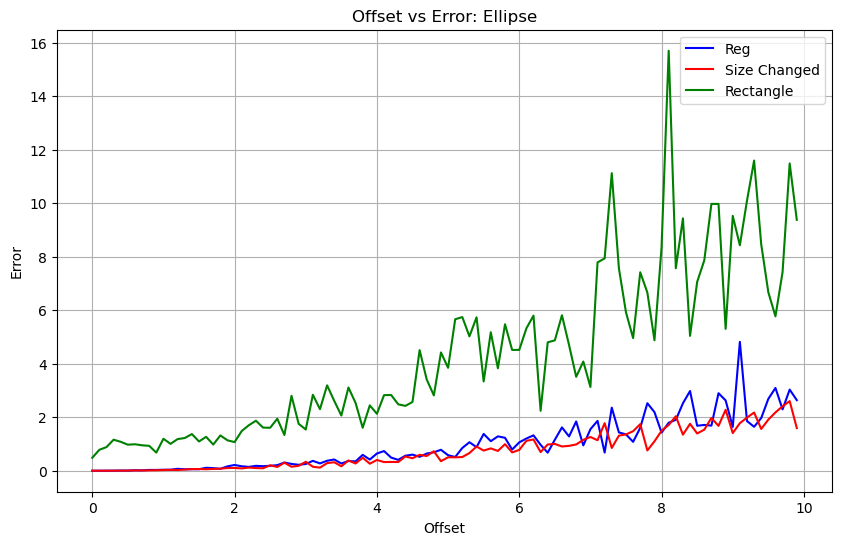

In [1142]:
# CALC - Generate many random ellipses and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

# Base case
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    center, axes, angle = fit_ellipse(points)
    error = calc_error(points, center, axes, angle)
    if not math.isnan(error):
        y1[i] = error
    else:
        y1[i] = y1[i - 1]

y2 = np.zeros_like(x)

# Change ellipse shape
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 30, b = 30, center = [50, 50], offset = val, angle = 0)
    center, axes, angle = fit_ellipse(points)
    error = calc_error(points, center, axes, angle)
    if not math.isnan(error):
        y2[i] = error
    else:
        y2[i] = y2[i - 1] # smooth graph if error

y3 = np.zeros_like(x)

# Rect instead of ellipse
for i, val in enumerate(x):
    points = rect_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val)
    center, axes, angle = fit_ellipse(points)
    error = calc_error(points, center, axes, angle)
    if not math.isnan(error):
        y3[i] = error
    else:
        y3[i] = y3[i - 1] # smooth graph if error

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Size Changed')
plt.plot(x, y3, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Ellipse')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# NOTES: Changing the center, the angle has no effect on offset vs error
# If we double the offset, the error scales by 4 on avg
# If we double a or b, the error decreases by 2 on avg
# So if we double the size and the offset, error is the same - GOOD
# Even if a * b is constant, error is minimmized when a = b; long and skinny have higher error
# Even perfect rectangles have fairly high error - GOOD

2.1855016822536566
Center: (np.float64(49.4631871465959), np.float64(49.21319627572452))
Axes lengths: (np.float64(48.466279362606556), np.float64(23.366699513644004))
Rotation angle: -32.406401800362644 degrees


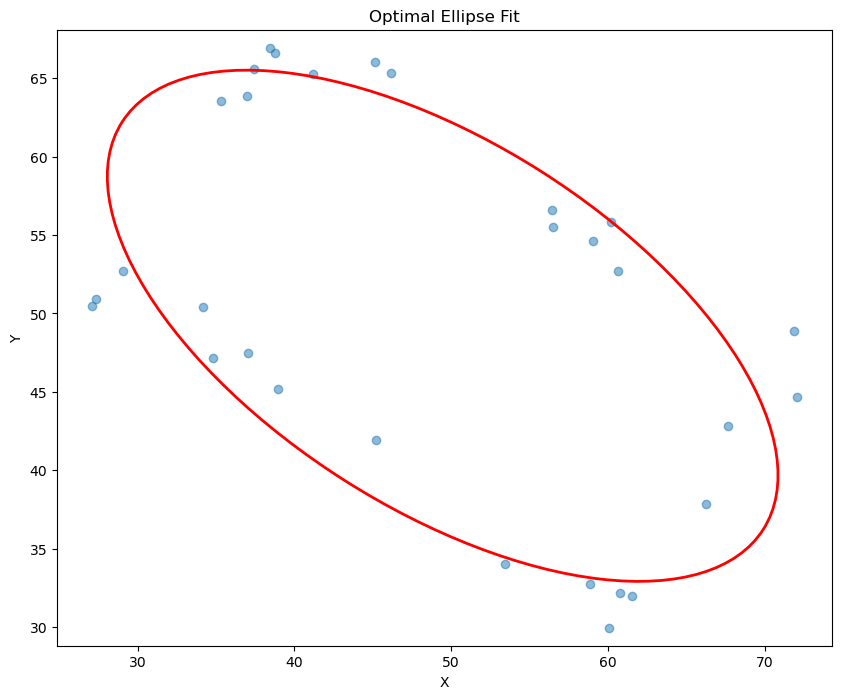

In [1089]:
# CALC - Demo of optimal ellipse
test_pts = rect_pts(30, 20, 40, [50, 50], 2, 1)
center, axes, angle = fit_ellipse(test_pts)
print(calc_error(test_pts, center, axes, angle))
plot_results(test_pts, center, axes, angle)

# Optimal Rectangle

Finds a close to optimal rectangle and gives the error associated with it.

In [1432]:
from scipy.optimize import minimize_scalar

def compute_centroid(points):
    return np.mean(points, axis=0)

def compute_major_axis_angle(points):
    centered = points - compute_centroid(points)
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    return np.arctan2(eigvecs[1, np.argmax(eigvals)], eigvecs[0, np.argmax(eigvals)])

def rotate_points(points, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(points - compute_centroid(points), rotation_matrix.T)

def compute_rectangle(rotated_points):
    min_x, min_y = np.percentile(rotated_points, 10, axis=0)
    max_x, max_y = np.percentile(rotated_points, 90, axis=0)
    return np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]])

def rotate_rectangle(rectangle, angle, centroid):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    return np.dot(rectangle, rotation_matrix.T) + centroid

def mean_squared_distance(points, rectangle):
    def point_to_rectangle_distance(point):
        x, y = point
        x1, y1 = rectangle[0]
        x2, y2 = rectangle[2]
        
        # Calculate distances to all edges
        left_dist = abs(x - x1)
        right_dist = abs(x - x2)
        top_dist = abs(y - y1)
        bottom_dist = abs(y - y2)
        
        min_dist = min(left_dist, right_dist, top_dist, bottom_dist)
        
        return min_dist**2
    
    distances = np.array([point_to_rectangle_distance(p) for p in points])
    return np.mean(distances)

def objective_function(angle, points):
    rotated = rotate_points(points, angle)
    rectangle = compute_rectangle(rotated)
    return mean_squared_distance(rotated, rectangle)

def fit_rectangle(points):
    centroid = compute_centroid(points)
    initial_angle = compute_major_axis_angle(points)
    
    result = minimize_scalar(
        lambda angle: objective_function(angle, points),
        method='brent',
        bracket=(initial_angle - np.pi/4, initial_angle + np.pi/4)
    )
    
    best_angle = result.x
    rotated_points = rotate_points(points, best_angle)
    best_rectangle = compute_rectangle(rotated_points)
    final_msd = objective_function(best_angle, points)
    
    return rotate_rectangle(best_rectangle, -best_angle, centroid), final_msd

# Error function (adjustable)
def rect_error(rectangle, msd):
    def rect_area(vertices):
        if vertices.shape[0] != 4:
            raise ValueError("There must be exactly four vertices.")
        
        # Extract the vertices
        x = vertices[:, 0]
        y = vertices[:, 1]
        
        # Calculate the side lengths using the distance formula
        side1 = ((x[1] - x[0])**2 + (y[1] - y[0])**2)**0.5
        side2 = ((x[2] - x[1])**2 + (y[2] - y[1])**2)**0.5
        
        # The area of the rectangle is the product of the two side lengths
        area = side1 * side2
        
        return area
    area = rect_area(rectangle)
    error = msd / (area) * 10000
    return error

# Print the results
def rect_results(rectangle, error):
    print("Best-fitted rectangle vertices:")
    print(rectangle)
    print("Error:")
    print(error)

    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
    plt.plot(np.append(rectangle[:, 0], rectangle[0, 0]),
                np.append(rectangle[:, 1], rectangle[0, 1]), 'r-')
    plt.axis('equal')
    plt.title('Best-fitted Rectangle')
    plt.show()

Best-fitted rectangle vertices:
[[68.41603329 37.30569839]
 [71.20343487 57.11039078]
 [32.00570701 62.62725551]
 [29.21830542 42.82256312]]
Error:
0.23580442292776113


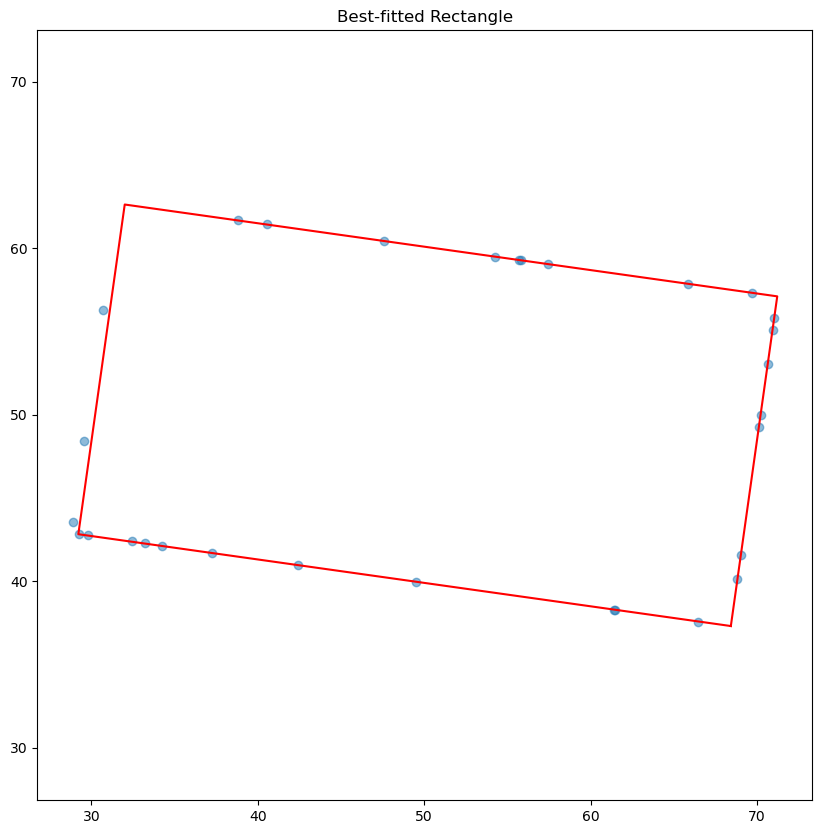

In [1442]:
# CALC - Demo of optimal rectangle
points =  rect_pts(30, 40, 20, [50, 50], 0, 3)
rectangle, msd = fit_rectangle(points)
error = rect_error(rectangle, msd)
rect_results(rectangle, error)

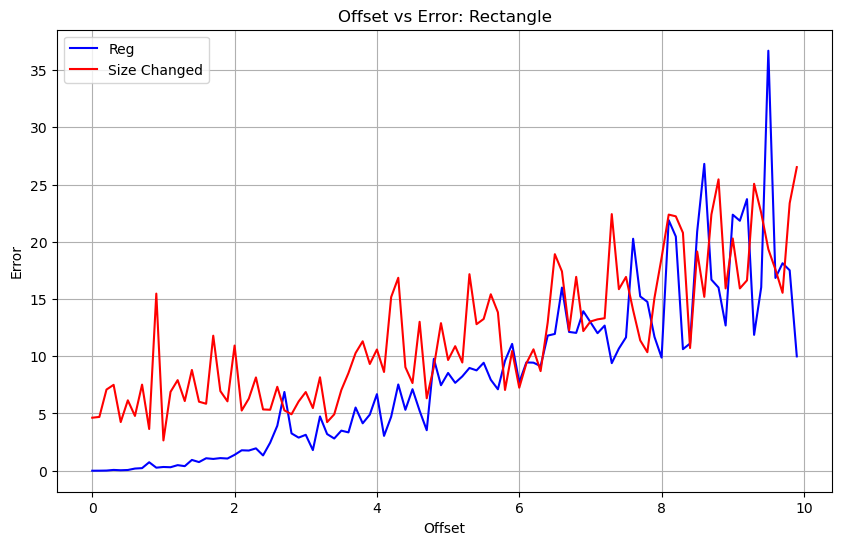

In [1275]:
# CALC - Generate many random rectangles and compare error to offset - numerical testing
x = np.arange(0, 10, 0.1)
y1 = np.zeros_like(x)

# Base case
for i, val in enumerate(x):
    points = rect_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    rectangle, error = fit_rectangle(points)
    y1[i] = error

y2 = np.zeros_like(x)

# Ellipse
for i, val in enumerate(x):
    points = ell_pts(num_pt = 30, a = 20, b = 40, center = [50, 50], offset = val, angle = 0)
    rectangle, error = fit_rectangle(points)
    y2[i] = error

# Create the plot
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(x, y1, color='blue', label='Reg')
plt.plot(x, y2, color='red', label='Size Changed')
# plt.plot(x, y3, color='green', label='Rectangle')

# Customize the plot
plt.title('Offset vs Error: Rectangle')
plt.xlabel('Offset')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# NOTES: Changing the center has no effect on error
# Changing the angle has no effect on error
# If we double the offset, the error scales by ~3 on avg
# If we double a and b, the error slightly increases; it should, however, decrease - BAD
# Error minimized when a = b; but also decreases when extremely long and skinny - may be BAD
# Even perfect ellipses have much higher error for small offset values - GOOD

TO DO WED:
- Implement best fit and error for stars, triangles - use similar method as rectangles, but adjust error function
- Implement thresholding - cutoff on if shape perfect should depend on error, size, length/width
- Test on various path elements, and also on segments from segmentation/contours from image - point sets derived from the image